## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-media/competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
# ваш код здесь
taxi_data['pickup_datetime'] = pd.to_datetime(
    taxi_data['pickup_datetime'],
    format='%Y-%m-%d %H:%M:%S'
)

print(f"Временные рамки в датасете: {taxi_data['pickup_datetime'].min()} - {taxi_data['pickup_datetime'].max()}")

Временные рамки в датасете: 2016-01-01 00:00:17 - 2016-06-30 23:59:39


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [4]:
# ваш код здесь
taxi_data.isnull().sum().sum()

np.int64(0)

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [5]:
# ваш код здесь
print(f"Количество уникальных таксопарков: {taxi_data['vendor_id'].nunique()}")
print(f"Максимальное количество пассажиров: {taxi_data['passenger_count'].max()}")
print(f"Средняя длительность поездки: {taxi_data['trip_duration'].mean().round()} секунд.\n"
      f"Медианная продолжительность поездки: {taxi_data['trip_duration'].median().round()} секунд")
print(f"Минимальная продолжительность поездки: {taxi_data['trip_duration'].min()} секунд\n"
      f"Максимальная продолжительность поездки: {taxi_data['trip_duration'].max()} секунд")

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность поездки: 959.0 секунд.
Медианная продолжительность поездки: 662.0 секунд
Минимальная продолжительность поездки: 1 секунд
Максимальная продолжительность поездки: 3526282 секунд


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [6]:
# ваш код здесь
# 1. Функция
def add_datetime_features(df):
    """Функция добавления временных признаков

    Args:
        df (dataframe): исходный датасет

    Returns:
        dataframe: датасет с добавленными признаками
    """
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

# 2. Применяем
taxi_data = add_datetime_features(taxi_data)

# 3. Считаем поездки в субботу
saturday_rides = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
print("Количество поездок в субботу:", saturday_rides)

# 4. Среднее за день
num_days = taxi_data['pickup_date'].nunique()
avg_rides_per_day = round(taxi_data.shape[0] / num_days)
print("Среднее количество поездок за день:", avg_rides_per_day)

Количество поездок в субботу: 220868
Среднее количество поездок за день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [7]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

# ваш код здесь

# 1. Функция
def add_holiday_features(taxi_df, holiday_df):
    """Функция добавляет данные с праздничными днями

    Args:
        taxi_df (dataframe): датасет с поездками
        holiday_df (dataframe): датасет с праздниками

    Returns:
        dataframe: датасет с добавленным бинарным признаком
    """
    holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date

    if 'pickup_date' not in taxi_df.columns:
        taxi_df['pickup_date'] = taxi_df['pickup_datetime'].dt.date

    taxi_df['pickup_holiday'] = taxi_df['pickup_date'].isin(holiday_df['date']).astype(int)
    return taxi_df

# 2. Применяем
taxi_data = add_holiday_features(taxi_data, holiday_data)

# 3. Медианная длительность
holiday_median = round(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())

print("Медианная длительность поездки в праздничные дни (сек):", holiday_median)


Медианная длительность поездки в праздничные дни (сек): 585


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [8]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

# ваш код здесь

def add_osrm_features(taxi_df, osrm_df):
    """Фунция добавления признаков из osrm

    Args:
        taxi_df (dataframe): датассет с поездками
        osrm_df (dataframe): датасет osmr

    Returns:
        dataframe: датасет с добавленными признаками
    """
    osrm_cols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
    osrm_df = osrm_df[osrm_cols]
    merged_df = taxi_df.merge(osrm_df, on='id', how='left')
    return merged_df

# Применяем
taxi_data = add_osrm_features(taxi_data, osrm_data)

# Разница медианных длительностей
median_trip = taxi_data['trip_duration'].median()
median_osrm = taxi_data['total_travel_time'].median()
diff = round(median_trip - median_osrm)
print(f"Разница медианных длительностей: {diff} секунд")

# Считаем пропуски
missing_rows = taxi_data[
    taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isna().any(axis=1)
].shape[0]

print("Количество строк с пропусками:", missing_rows)


Разница медианных длительностей: 372 секунд
Количество строк с пропусками: 1


In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [10]:
# ваш код здесь

# Функция добавления признаков
def add_geographical_features(df):
    """Функция принимает на вход таблицу с данными о поездках и возвращает обновлённую таблицу с добавленными в неё двумя столбцами:

    haversine_distance — расстояние по формуле гаверсинуса между точкой, в которой был включён счетчик, и точкой, в которой счётчик был выключен;
    direction — направление движения из точки, в которой был включён счётчик, в точку, в которой счётчик был выключен.

    Args:
        df (dataframe): датасет с поездками

    Returns:
        dataframe: датасет с добавленными признаками
    """
    df['haversine_distance'] = get_haversine_distance(
        df['pickup_latitude'],
        df['pickup_longitude'],
        df['dropoff_latitude'],
        df['dropoff_longitude']
    )
    df['direction'] = get_angle_direction(
        df['pickup_latitude'],
        df['pickup_longitude'],
        df['dropoff_latitude'],
        df['dropoff_longitude']
    )
    return df

# Применяем
taxi_data = add_geographical_features(taxi_data)

# Медианное расстояние
median_haversine = round(taxi_data['haversine_distance'].median(), 2)
print("Медианное гаверсиновое расстояние (км):", median_haversine)

Медианное гаверсиновое расстояние (км): 2.09


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [11]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# ваш код здесь

# 1. Функция
def add_cluster_features(df, kmeans_model):
    """Функция принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации и возвращает
    обновлённую таблицу с добавленным в неё столбцом geo_cluster (географический кластер, к которому относится поездка)

    Args:
        df (dataframe): датасет с поездками
        kmeans_model (model): обученная модель кластеризации

    Returns:
        datafranme: датасет с новым признаком кластера
    """
    coords = np.hstack((
        df[['pickup_latitude', 'pickup_longitude']],
        df[['dropoff_latitude', 'dropoff_longitude']]
    ))
    df['geo_cluster'] = kmeans_model.predict(coords)
    return df

# 2. Применяем
taxi_data = add_cluster_features(taxi_data, kmeans)

# 3. Наименьший кластер
min_cluster_size = taxi_data['geo_cluster'].value_counts().min()
print("Число поездок в наименьшем гео-кластере:", min_cluster_size)

Число поездок в наименьшем гео-кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [12]:
weather_data = pd.read_csv('data/weather_data.csv')

# ваш код здесь
def add_weather_features(taxi_df, weather_df):
    """
    Добавляет погодные характеристики к таблице с поездками.

    Таблицы объединяются по дате и часу начала поездки.
    В итоговую таблицу добавляются столбцы: temperature, visibility, wind speed, precip и events.

    Args:
        taxi_df (DataFrame): Таблица с данными о поездках. 
                            Ожидается наличие столбцов 'pickup_datetime'.
        weather_df (DataFrame): Таблица с погодными данными. 
                            Ожидается наличие столбца 'time' в формате даты и времени.

    Returns:
        DataFrame: Исходная таблица поездок с добавленными погодными признаками.
    """
    weather_df = weather_df[['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']].copy()
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df['date'] = weather_df['time'].dt.date
    weather_df['hour'] = weather_df['time'].dt.hour

    if 'pickup_date' not in taxi_df.columns:
        taxi_df['pickup_date'] = taxi_df['pickup_datetime'].dt.date
    if 'pickup_hour' not in taxi_df.columns:
        taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.hour

    merged_df = taxi_df.merge(
        weather_df,
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'],
        how='left'
    )
    merged_df.drop(columns=['date', 'hour', 'time'], inplace=True)
    return merged_df

# Применяем
taxi_data = add_weather_features(taxi_data, weather_data)

# Снег
snow_trips = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
print("Число поездок в снежную погоду:", snow_trips)

# Доля пропусков
weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
missing_weather = taxi_data[weather_columns].isna().any(axis=1).sum()
missing_share = round(missing_weather / taxi_data.shape[0] * 100, 2)
print(f"Доля пропусков в погодных столбцах: {missing_share}%")

Число поездок в снежную погоду: 13126
Доля пропусков в погодных столбцах: 0.82%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [13]:
# ваш код здесь
def fill_null_weather_data(data):
    """
    Заполняет пропущенные значения в таблице с поездками.

    Пропуски в погодных столбцах заполняются медианным значением по каждой дате поездки.
    Пропуски в столбце 'events' заполняются строкой 'None'.
    Пропуски в столбцах с OSRM-данными заполняются медианой по всему столбцу.

    Args:
        data (DataFrame): Таблица с данными о поездках.

    Returns:
        DataFrame: Таблица с заполненными пропусками.
    """
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_cols:
        data[col] = data[col].fillna(
            data.groupby('pickup_date')[col].transform('median')
        )

    data['events'] = data['events'].fillna('None')

    osrm_cols = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_cols:
        data[col] = data[col].fillna(data[col].median())

    return data

# Применяем
taxi_data = fill_null_weather_data(taxi_data)

# Итоговая медиана температуры
median_temp = round(taxi_data['temperature'].median(), 1)
print("Медиана температуры после заполнения:", median_temp)

Медиана температуры после заполнения: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


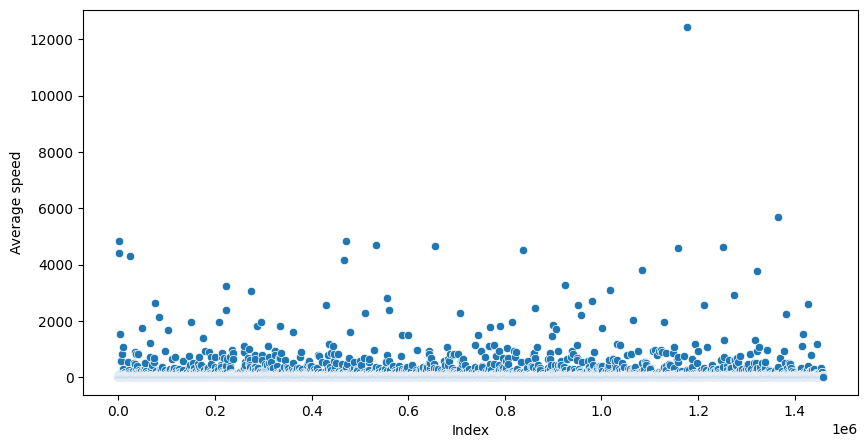

In [14]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [15]:
# ваш код здесь
# Выбросы по длительности
long_trips = taxi_data[taxi_data['trip_duration'] > 86400]
taxi_data = taxi_data[taxi_data['trip_duration'] <= 86400]
print(f"Число выбросов по длительности поездки (>24ч): {long_trips.shape[0]}")

# avg_speed для обновлённого taxi_data!
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

# Теперь фильтрация по скорости — индексы совпадают
fast_trips = taxi_data[avg_speed > 300]
taxi_data = taxi_data[avg_speed <= 300]
print(f"Число выбросов по скорости (>300 км/ч): {fast_trips.shape[0]}")

Число выбросов по длительности поездки (>24ч): 4
Число выбросов по скорости (>300 км/ч): 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [16]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

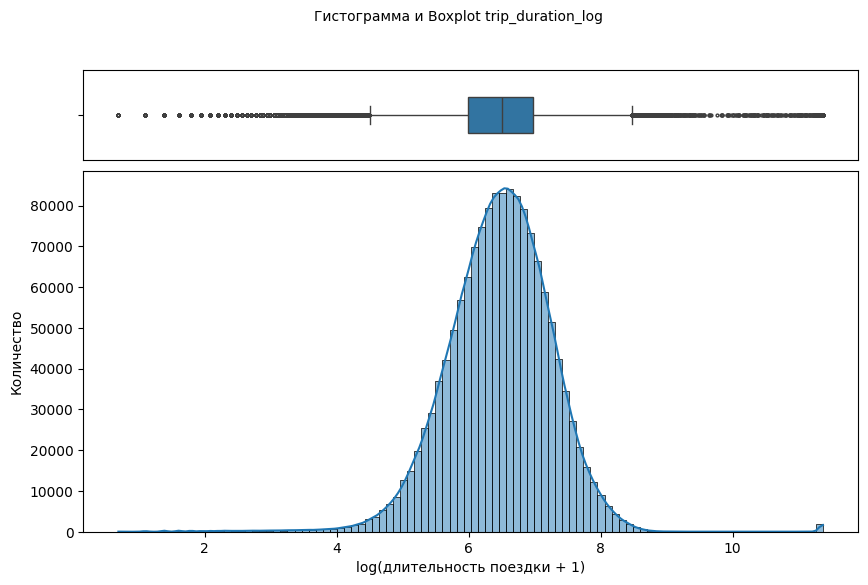

p-value: 0.00
Отклоняем гипотезу о нормальности распределения.


In [58]:
# ваш код здесь
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], hspace=0.05)

# Верхний график — boxplot
ax0 = fig.add_subplot(gs[0])
sns.boxplot(x=taxi_data['trip_duration_log'], ax=ax0, width=0.4, fliersize=2)
ax0.set(xlabel='')
ax0.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # скрыть подписи по x

# Нижний график — гистограмма
ax1 = fig.add_subplot(gs[1], sharex=ax0)
sns.histplot(taxi_data['trip_duration_log'], bins=100, kde=True)
ax1.set_xlabel('log(длительность поездки + 1)')
ax1.set_ylabel('Количество')

plt.suptitle('Гистограмма и Boxplot trip_duration_log', fontsize=10)

plt.show()

# Тест Д’Агостино-Пирсона
stat, p_value = stats.normaltest(taxi_data['trip_duration_log'])
print(f"p-value: {p_value:.2f}")

# Уровень значимости
alpha = 0.05

if p_value < alpha:
    print("Отклоняем гипотезу о нормальности распределения.")
else:
    print("Нет оснований отклонять гипотезу о нормальности.")

[Посмотреть интерактивный график](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_3_1.html)

In [ ]:
'''
Код для интерактивного графика plotly

fig = px.histogram(
    taxi_data,
    x='trip_duration_log',
    title='Гистограмма и Boxplot trip_duration_log',
    marginal='box',  
    labels={'trip_duration_log': 'log(длительность поездки + 1)'},
    height=400, width=800
)
fig.show()
'''

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

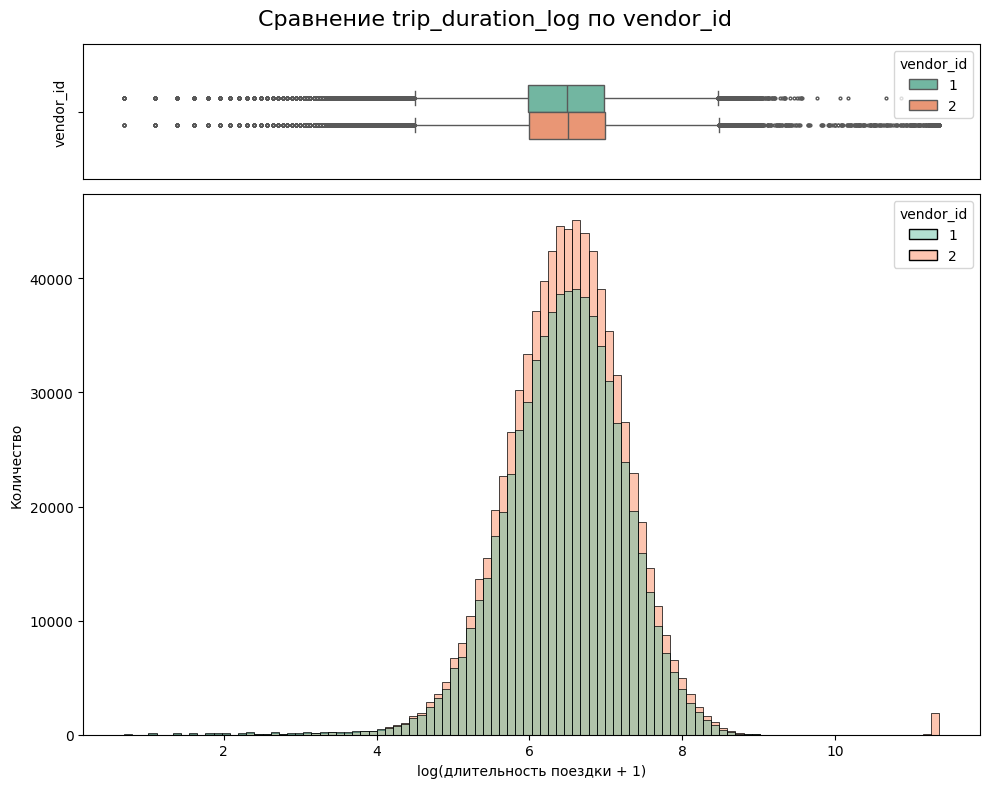

In [ ]:
# ваш код здесь
fig, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, 
                                      gridspec_kw={"height_ratios": (1, 4)}, figsize=(10, 8))

sns.boxplot(x='trip_duration_log', hue='vendor_id', data=taxi_data, ax=ax_box, width=0.4, fliersize=2, showfliers=True, palette='Set2')
ax_box.set_xlabel('')
ax_box.set_ylabel('vendor_id')
ax_box.tick_params(axis='x', bottom=False, labelbottom=False)

sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', 
             bins=100, alpha=0.5, multiple='layer', ax=ax_hist, palette='Set2')

ax_hist.set_xlabel('log(длительность поездки + 1)')
ax_hist.set_ylabel('Количество')

plt.suptitle('Сравнение trip_duration_log по vendor_id', fontsize=16)
plt.tight_layout()
plt.show()

[Посмотреть интерактивный график](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_3_2.html)

In [ ]:
'''
Код для интерактивного графика plotly

fig_box = px.box(
    taxi_data,
    y='store_and_fwd_flag',
    x='trip_duration_log',
    color='store_and_fwd_flag',
    points='outliers',
    title='Boxplot trip_duration_log по store_and_fwd_flag',
    height=250, width=900
)
fig_box.show()

# Гистограмма с логарифмом
fig_hist = px.histogram(
    taxi_data,
    x='trip_duration_log',
    color='store_and_fwd_flag',
    barmode='overlay',
    opacity=0.7,
    title='Гистограмма trip_duration_log по store_and_fwd_flag (лог шкала Y)',
    height=400, width=900
)
fig_hist.update_yaxes(type='log')
fig_hist.show()
'''

### Вывод:

Распределение логарифма длительности поездки (trip_duration_log) для разных таксопарков (vendor_id) практически совпадает по форме, положению медианы, диапазону значений и числу выбросов.

Следовательно, признак vendor_id не оказывает существенного влияния на длительность поездки и не является важным фактором для её прогнозирования.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

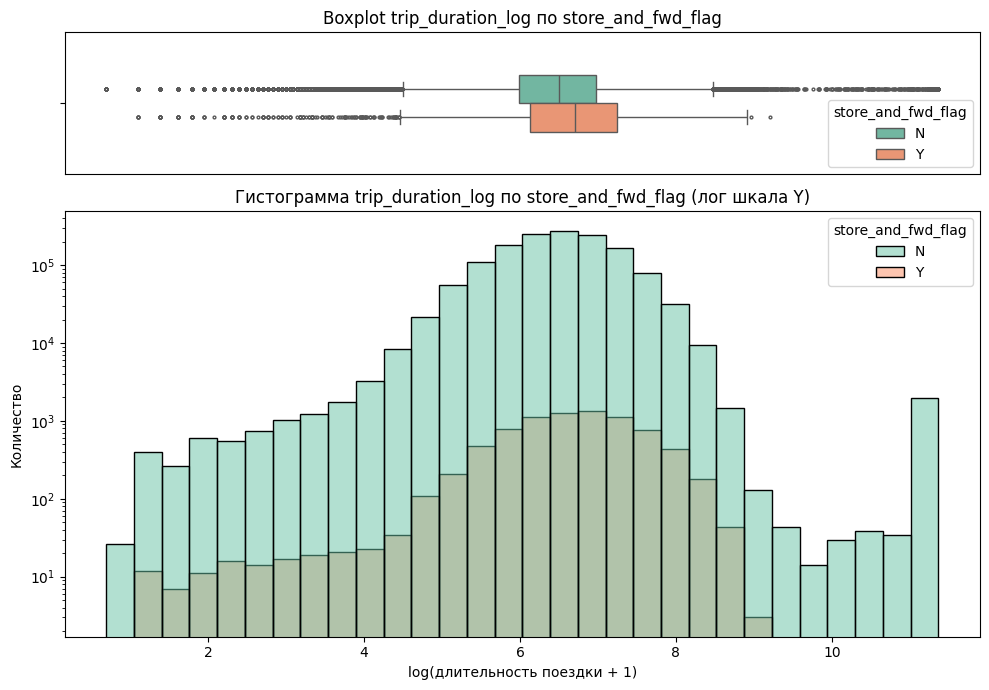

In [ ]:
# ваш код здесь
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

# Boxplot по категориям store_and_fwd_flag
sns.boxplot(
    x='trip_duration_log',
    hue='store_and_fwd_flag',
    data=taxi_data,
    ax=ax_box,
    showfliers=True,  # показываем выбросы 
    width=0.4,          # Уменьшаем ширину боксплота
    fliersize=2,         # Размер точек выбросов
    palette='Set2'
)
ax_box.set_xlabel('')
ax_box.set_title('Boxplot trip_duration_log по store_and_fwd_flag')
ax_box.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Гистограмма с прозрачностью и логарифмической осью Y
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    hue='store_and_fwd_flag',
    multiple='layer',   # overlay
    alpha=0.5,
    bins=30,
    palette='Set2',
    ax=ax_hist
)

ax_hist.set_yscale('log')
ax_hist.set_title('Гистограмма trip_duration_log по store_and_fwd_flag (лог шкала Y)')
ax_hist.set_xlabel('log(длительность поездки + 1)')
ax_hist.set_ylabel('Количество')

plt.tight_layout()
plt.show()

[Посмотреть интерактивный график boxplot](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_box_3_3.html)

[Посмотреть интерактивный график hist](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_hist_3_3.html)

In [ ]:
''' 
Код для интерактивного графика plotly

# Отдельный boxplot для категорий
fig_box = px.box(
    taxi_data,
    y='store_and_fwd_flag',
    x='trip_duration_log',
    color='store_and_fwd_flag',
    points='outliers',
    title='Boxplot trip_duration_log по store_and_fwd_flag',
    height=250, width=900
)
fig_box.show()

# Гистограмма с логарифмом
fig_hist = px.histogram(
    taxi_data,
    x='trip_duration_log',
    color='store_and_fwd_flag',
    barmode='overlay',
    opacity=0.7,
    title='Гистограмма trip_duration_log по store_and_fwd_flag (лог шкала Y)',
    height=400, width=900
)
fig_hist.update_yaxes(type='log')
fig_hist.show()
'''

### Вывод:

Анализ boxplot и гистограммы trip_duration_log показывает, что большинство поездок не передавались позже (store_and_fwd_flag = N), тогда как поездок с флагом Y существенно меньше.

Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

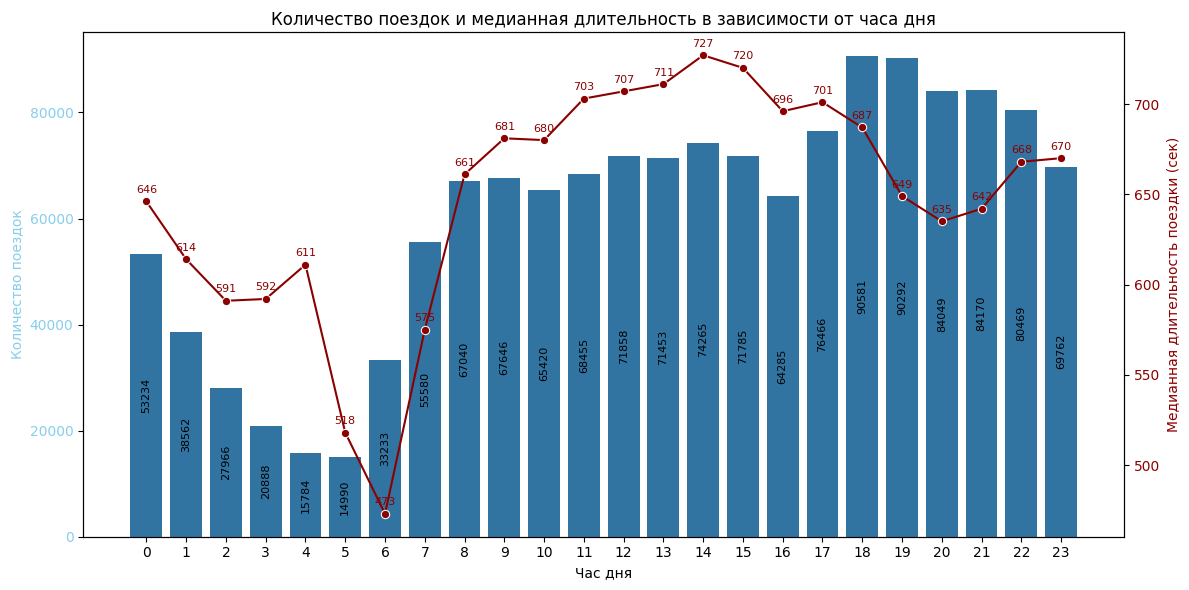

In [68]:
# ваш код здесь
# Данные
hour_counts = taxi_data['pickup_hour'].value_counts().sort_index()
hour_median_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# === Барчарт количества поездок ===
bars = sns.barplot(
    x=hour_counts.index,
    y=hour_counts.values,
    ax=ax1
)

# === Подписи ВНУТРИ столбиков, вертикально ===
for bar, label in zip(bars.patches, hour_counts.values):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,           # внутри, посередине по высоте
        str(label),
        ha='center',
        va='center',
        rotation=90,            # ПОВОРОТ на 90
        color='black',
        fontsize=8
    )

ax1.set_xlabel('Час дня')
ax1.set_ylabel('Количество поездок', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# === Линия медианной длительности ===
ax2 = ax1.twinx()  # вторая ось Y
sns.lineplot(
    data=hour_median_duration,
    x='pickup_hour',
    y='trip_duration',
    marker='o',
    color='darkred',
    ax=ax2
)

# Подписи медианной длительности над точками
for x, y in zip(hour_median_duration['pickup_hour'], hour_median_duration['trip_duration']):
    ax2.text(
        x, y + max(hour_median_duration['trip_duration'])*0.005,  # немного выше точки
        f'{int(y)}',  # округляем
        ha='center',
        va='bottom',
        fontsize=8,
        color='darkred'
    )

ax2.set_ylabel('Медианная длительность поездки (сек)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title('Количество поездок и медианная длительность в зависимости от часа дня')
plt.xticks(range(0, 24, 1))

plt.tight_layout()
plt.show()


[Посмотреть интерактивный график count](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_count_3_4.html)

[Посмотреть интерактивный график medien](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_median_3_4.html)

In [ ]:
''' 
Код для интерактивного графика plotly

# Считаем количество поездок по часам
hour_counts = taxi_data['pickup_hour'].value_counts().sort_index()

fig_count = px.bar(
    x=hour_counts.index,
    y=hour_counts.values,
    labels={'x': 'Час дня', 'y': 'Количество поездок'},
    title='Количество поездок в зависимости от часа дня',
    height=500, width=900,
    text=hour_counts.values
)
fig_count.update_traces(textposition='inside')

fig_count.update_xaxes(
    tickmode='linear',  
    dtick=1             # шаг = 1 час
)
fig_count.show()

# Считаем медиану по часам
hour_median_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()

fig_median = px.line(
    hour_median_duration,
    x='pickup_hour',
    y='trip_duration',
    markers=True,
    labels={'pickup_hour': 'Час дня', 'trip_duration': 'Медианная длительность поездки (сек)'},
    title='Медианная длительность поездки в зависимости от часа дня',
    height=400, width=900
)
fig_median.update_xaxes(
    tickmode='linear',  
    dtick=1             
)
fig_median.show()
'''

### Выводы:

Минимальное количество заказов такси наблюдается в ночное время с 00:00 по 5:00. В это время активность людей снижена, что приводит к редкому использованию такси.

Пик медианной длительности поездок приходится на дневное-вечернее время с 13:00 по 18:00. Это связано с часами пик, когда дорожное движение наиболее интенсивное, и поездки занимают больше времени из-за пробок.

Таким образом, такси реже всего заказывают ранним утром, а самая долгая медианная продолжительность поездок наблюдается в часы пик днем и вечером.

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


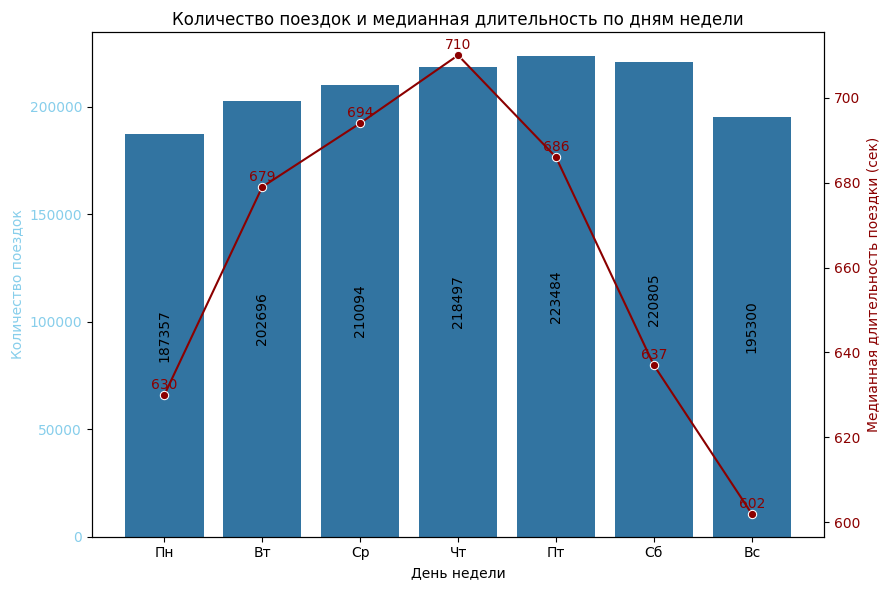

In [76]:
# ваш код здесь
# Считаем количество поездок по дням недели
day_of_week_counts = taxi_data['pickup_day_of_week'].value_counts().sort_index()

# Считаем медиану по дням недели
day_of_week_median_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()

day_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# График
fig, ax1 = plt.subplots(figsize=(9, 6))

# === Барчарт ===
bars = sns.barplot(
    x=day_of_week_counts.index,
    y=day_of_week_counts.values,
    ax=ax1
)

# Подписи внутри столбиков (вертикально)
for bar, label in zip(bars.patches, day_of_week_counts.values):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,
        str(label),
        ha='center',
        va='center',
        rotation=90,
        color='black',
        fontsize=10
    )

# Заменим метки оси X на слова
ax1.set_xticks(range(7))
ax1.set_xticklabels(day_labels)

ax1.set_xlabel('День недели')
ax1.set_ylabel('Количество поездок', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# === Линия медианы ===
ax2 = ax1.twinx()
sns.lineplot(
    data=day_of_week_median_duration,
    x='pickup_day_of_week',
    y='trip_duration',
    marker='o',
    color='darkred',
    ax=ax2
)

# Подписи медианы над точками
for x, y in zip(day_of_week_median_duration['pickup_day_of_week'], day_of_week_median_duration['trip_duration']):
    ax2.text(
        x,
        y + max(day_of_week_median_duration['trip_duration']) * 0.001,
        f'{int(y)}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='darkred'
    )

ax2.set_ylabel('Медианная длительность поездки (сек)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title('Количество поездок и медианная длительность по дням недели')
plt.xticks(range(0, 7, 1))  # дни недели: 0, 1, 2, ...
plt.tight_layout()
plt.show()

[Посмотреть интерактивный график count](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_count_3_5.html)

[Посмотреть интерактивный график median](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_median_3_5.html)

In [ ]:
''' 
Код для интерактивного графика в plotly 

# Считаем количество поездок по дням недели
day_of_week_counts = taxi_data['pickup_day_of_week'].value_counts().sort_index()

fig_count = px.bar(
    x=day_of_week_counts.index,
    y=day_of_week_counts.values,
    labels={'x': 'День недели', 'y': 'Количество поездок'},
    title='Количество поездок в зависимости от дня недели',
    height=400, width=700,
    text=day_of_week_counts.values
)
fig_count.update_traces(textposition='inside')

fig_count.update_xaxes(
    tickmode='linear',  
    dtick=1             # шаг = 1 день
)
fig_count.show()

# Считаем медиану по дням недели
day_of_week_median_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()

fig_median = px.line(
    day_of_week_median_duration,
    x='pickup_day_of_week',
    y='trip_duration',
    markers=True,
    labels={'pickup_day_of_week': 'День недели', 'trip_duration': 'Медианная длительность поездки (сек)'},
    title='Медианная длительность поездки в зависимости от День недели',
    height=400, width=700
)
fig_median.update_xaxes(
    tickmode='linear',  
    dtick=1             
)
fig_median.show()
'''

### Выводы:

1. Динамика спроса:

Пик заказов приходится на четверг-пятницу (218-223 тыс.), что может быть связано с:

* Активными деловыми поездками перед выходными
* Увеличением числа поездок на развлекательные мероприятия
* Возможным накоплением усталости к концу недели (люди чаще выбирают такси вместо общественного транспорта)

Минимум спроса в понедельник (187 тыс.) и воскресенье (195 тыс.):

* В понедельник - "раскачка" после выходных
* В воскресенье - низкая деловая активность и меньше мероприятий

2. Длительность поездок:

Самые долгие поездки в среду-четверг (690-710 сек):

* Связано с пробками в "офисные" дни
* Возможно больше дальних деловых поездок (в бизнес-центры, аэропорты)

Самые короткие поездки в воскресенье (602 сек):

* Меньше пробок
* Преобладают короткие поездки по личным делам

3. Интересные закономерности:

Обратная зависимость между количеством поездок и их длительностью:

* В дни с максимальным спросом (чт-пт) длительность средняя
* В дни с максимальной длительностью (ср-чт) количество поездок не максимальное

Пятница показывает:

* Максимальное количество поездок (223484)
* При этом среднюю длительность (~650 сек)
* Это может указывать на смешанный характер поездок (и деловые, и развлекательные)

Рекомендации для сервиса такси:

* Усиливать подачу машин в четверг-пятницу
* В среду-четверг учитывать возможные пробки при планировании маршрутов
* В воскресенье можно сокращать количество активных машин

Такая динамика характерна для крупных городов с выраженной деловой активностью в середине недели и увеличением развлекательных поездок к выходным.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

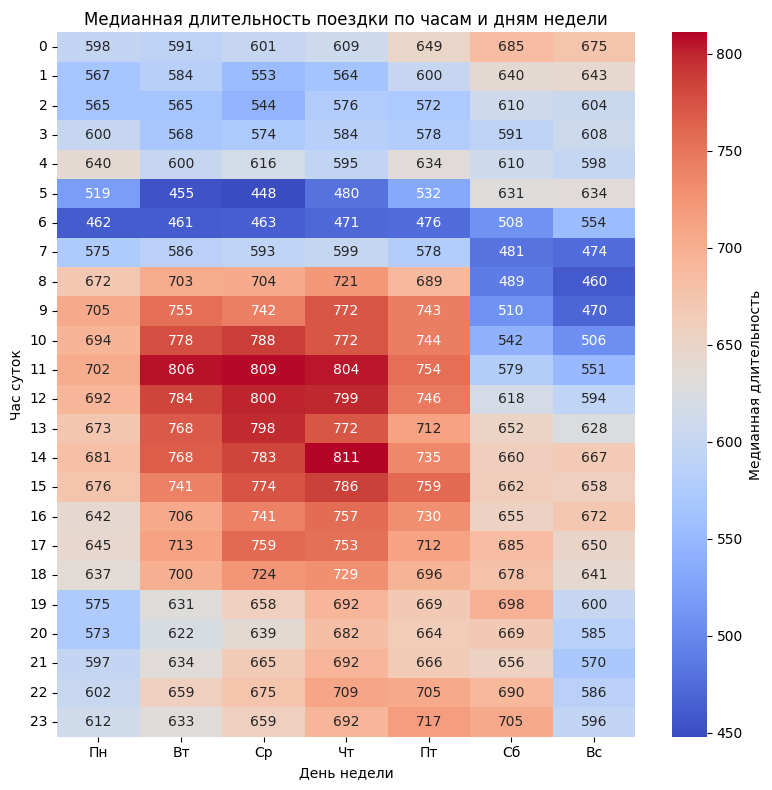

In [82]:
# ваш код здесь

# создаём сводную таблицу
pivot_table = taxi_data.pivot_table(
    index='pickup_hour',
    columns='pickup_day_of_week',
    values='trip_duration',
    aggfunc='median'
)

day_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
pivot_table.columns = day_labels

plt.figure(figsize=(8, 8))

sns.heatmap(
    pivot_table,
    annot=True,            # подписи значений внутри
    fmt='.0f',             # формат чисел
    cmap='coolwarm',         
    cbar_kws={'label': 'Медианная длительность'}
)

plt.title('Медианная длительность поездки по часам и дням недели')
plt.xlabel('День недели')
plt.ylabel('Час суток')

plt.yticks(rotation=0)     # чтобы часы были горизонтально
plt.xticks(rotation=0)     # чтобы дни недели были горизонтально

plt.tight_layout()
plt.show()

[Посмотреть интерактивный график heatmap](https://dafe1988.github.io/SF-DSPR-174/PROJECT_5_%20Regression/plotly/fig_3_6.html)

In [ ]:
''' 
Код для интерактивного графика в plotly 

# создаём сводную таблицу
pivot_table = taxi_data.pivot_table(
    index='pickup_hour',
    columns='pickup_day_of_week',
    values='trip_duration',
    aggfunc='median'
)
# Строим тепловую карту через px.imshow
fig = px.imshow(
    pivot_table.values,
    labels=dict(x="День недели", y="Час суток", color="Медианная длительность"),
    x=pivot_table.columns,
    y=pivot_table.index,
    text_auto=".1f",        # подписи значений
    color_continuous_scale='RdBu',
    height=1200, width=1000
)

fig.update_layout(
    title='Медианная длительность поездки по часам и дням недели',
    xaxis_title="День недели",
    yaxis_title="Час суток"
)
fig.update_yaxes(
    tickmode='linear',  
    dtick=1             
)
fig.update_xaxes(
    tickmode='linear',  
    dtick=1             
)

fig.show()
'''

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов. 

Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


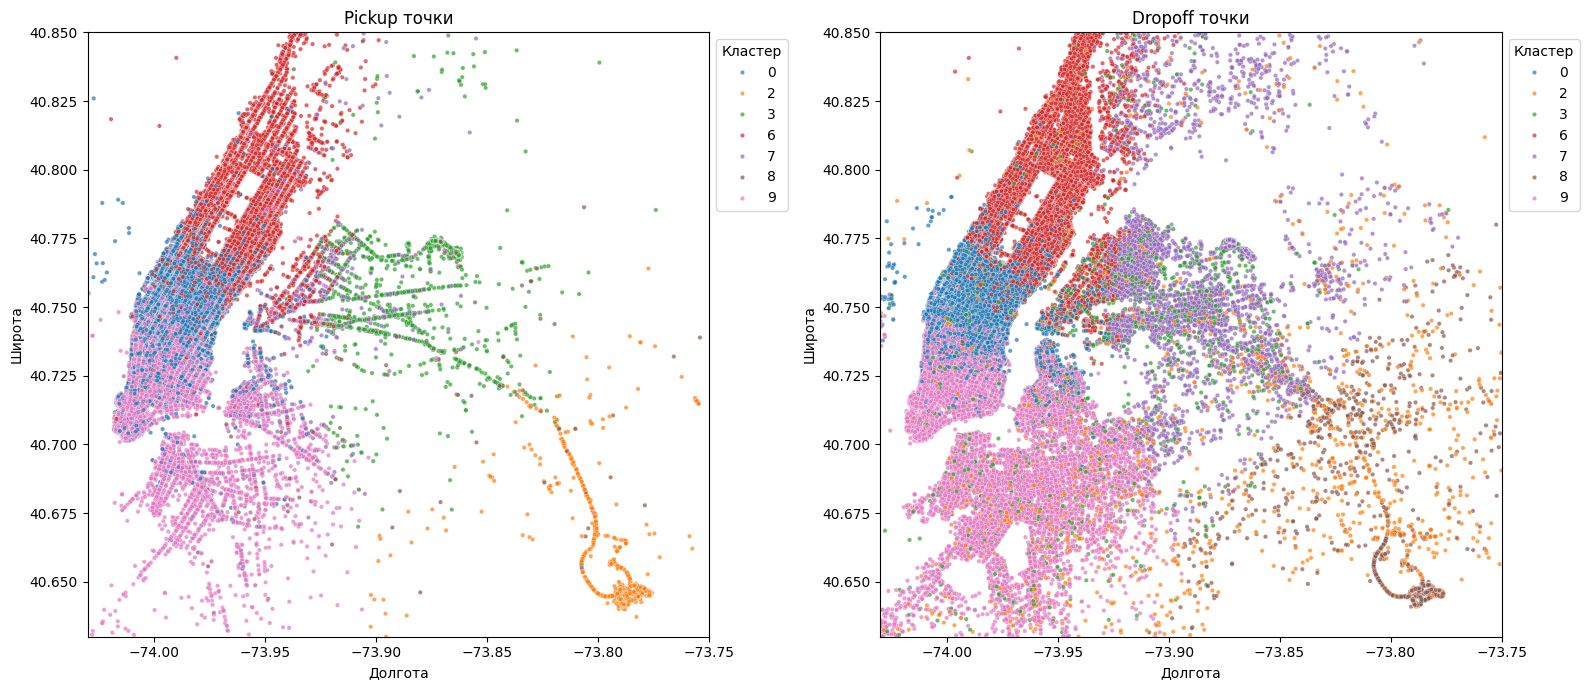

In [88]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь
# Фильтруем данные
pickup_points = taxi_data[
    (taxi_data['pickup_longitude'].between(*city_long_border)) &
    (taxi_data['pickup_latitude'].between(*city_lat_border))
]

dropoff_points = taxi_data[
    (taxi_data['dropoff_longitude'].between(*city_long_border)) &
    (taxi_data['dropoff_latitude'].between(*city_lat_border))
]

# Сэмплирование для облегчения расчетов:
pickup_points = pickup_points.sample(frac=0.2, random_state=42)
dropoff_points = dropoff_points.sample(frac=0.2, random_state=42)

plt.figure(figsize=(16, 7))

# Первый subplot — pickup
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=pickup_points,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    palette='tab10',
    s=10,           # размер маркеров
    alpha=0.7
)
plt.title('Pickup точки')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend(title='Кластер', bbox_to_anchor=(1, 1))

# Второй subplot — dropoff
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=dropoff_points,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='tab10',
    s=10,           # размер маркеров
    alpha=0.7
)
plt.title('Dropoff точки')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend(title='Кластер', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [85]:
all_clusters = set(taxi_data['geo_cluster'].unique())
pickup_clusters = set(pickup_points['geo_cluster'].unique())
dropoff_clusters = set(dropoff_points['geo_cluster'].unique())

pickup_not_in = all_clusters - pickup_clusters
dropoff_not_in = all_clusters - dropoff_clusters
not_in_either = pickup_not_in.union(dropoff_not_in)

print(f"Кластеры вне pickup: {pickup_not_in}")
print(f"Кластеры вне dropoff: {dropoff_not_in}")
print(f"Кластеры вне хотя бы одной карты: {not_in_either}")
print(f"Всего кластеров вне NYC: {len(not_in_either)}")

Кластеры вне pickup: {np.int32(1), np.int32(4), np.int32(5)}
Кластеры вне dropoff: {np.int32(1), np.int32(4), np.int32(5)}
Кластеры вне хотя бы одной карты: {np.int32(1), np.int32(4), np.int32(5)}
Всего кластеров вне NYC: 3


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [ ]:
# ваш код здесь

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [ ]:
# ваш код здесь

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [ ]:
# ваш код здесь

Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
# ваш код здесь

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# ваш код здесь

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# ваш код здесь

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
# ваш код здесь

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [ ]:
# ваш код здесь

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# ваш код здесь

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)